# TF Neural Network Model Classification (Binary class): DRILL(BPD) and NHOLD

## Data Collection from Sensors 'Right Hand Side' (Absolute data).

## Loading the Libraries that we're going to use

In [183]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
import tensorflow.keras as kr
import os
import datetime
import keras_tuner as kt
import matplotlib.ticker as mtick
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Prepairing Data:

In [184]:
def process_file(filepath, pers_ratio=1):
    with open(filepath) as json_file:
        data = json.load(json_file)
    X_arr = []
    for k in range(len(data)):
        arr = []
        for i in range(7, 14):    # load the components of the right hand glove
            arr.extend(list(data[k]['sensors'][i]['quaternion'].values()))
        X_arr.append(arr)
    columns = ['7_W', '7_X', '7_Y', '7_Z','8_W', '8_X', '8_Y', '8_Z','9_W', '9_X', '9_Y', '9_Z',
               '10_W', '10_X', '10_Y', '10_Z','11_W', '11_X', '11_Y', '11_Z','12_W', '12_X', '12_Y', '12_Z','13_W', '13_X', '13_Y', '13_Z']
    df = pd.DataFrame(X_arr, columns=columns)    # transform the list of quaternion Components to dataframe
    df = df.sample(frac=pers_ratio)    # shuffle dataframe
    return df

In [185]:
# saving the list of the directory
filepaths_BPD = ['Data/Data_BPD/'+file for file in os.listdir('Data/Data_BPD')]
filepaths_NHOLD = ['Data/Data_NHOLD/'+file for file in os.listdir('Data/Data_NHOLD')]
filepaths_BPD_valid = filepaths_BPD[:2]
filepaths_NHOLD_valid = filepaths_NHOLD[:2]
filepaths_BPD = filepaths_BPD[2:]
filepaths_NHOLD = filepaths_NHOLD[2:]
filepaths_BPD_test = ['Data/test_BPD/'+file for file in os.listdir('Data/test_BPD')]
filepaths_NHOLD_test = ['Data/test_NHOLD/'+file for file in os.listdir('Data/test_NHOLD')]

In [186]:
len(filepaths_BPD), len(filepaths_NHOLD), len(filepaths_BPD_valid), len(filepaths_NHOLD_valid), len(filepaths_BPD_test), len(filepaths_NHOLD_test)

(17, 17, 2, 2, 1, 1)

In [187]:
dfs = []
for filepath in filepaths_BPD:
    df = process_file(filepath)
    dfs.append(df)
data_BPD = pd.concat(dfs, ignore_index=True)

dfs = []
for filepath in filepaths_NHOLD:
    df = process_file(filepath)
    dfs.append(df)
data_NHOLD = pd.concat(dfs, ignore_index=True)

dfs = []
for filepath in filepaths_BPD_valid:
    df = process_file(filepath)
    dfs.append(df)
valid_BPD = pd.concat(dfs, ignore_index=True)

dfs = []
for filepath in filepaths_NHOLD_valid:
    df = process_file(filepath)
    dfs.append(df)
valid_NHOLD = pd.concat(dfs, ignore_index=True)

dfs = []
for filepath in filepaths_BPD_test:
    df = process_file(filepath)
    dfs.append(df)
test_BPD = pd.concat(dfs, ignore_index=True)

dfs = []
for filepath in filepaths_NHOLD_test:
    df = process_file(filepath)
    dfs.append(df)
test_NHOLD = pd.concat(dfs, ignore_index=True)

In [188]:
data_BPD

,7_W,7_X,7_Y,7_Z,8_W,8_X,8_Y,8_Z,9_W,9_X,...,11_Y,11_Z,12_W,12_X,12_Y,12_Z,13_W,13_X,13_Y,13_Z
0,0.62,0.10,0.75,0.19,-0.12,-0.50,0.05,0.85,0.13,-0.72,...,0.20,0.63,0.77,0.20,-0.32,0.52,0.0,0.0,0.0,0.0
1,0.53,-0.21,0.70,0.43,-0.85,-0.14,-0.50,0.11,-0.62,-0.21,...,-0.61,0.48,-0.66,0.12,0.25,0.70,0.0,0.0,0.0,0.0
2,0.63,0.10,0.75,0.17,-0.08,-0.50,0.06,0.86,0.15,-0.73,...,0.19,0.62,0.77,0.20,-0.31,0.52,0.0,0.0,0.0,0.0
3,0.64,0.07,0.73,0.23,-0.05,-0.50,0.03,0.87,0.19,-0.73,...,0.12,0.64,0.73,0.24,-0.29,0.57,0.0,0.0,0.0,0.0
4,0.38,-0.36,0.79,-0.32,-0.63,-0.77,-0.14,-0.01,-0.58,-0.77,...,-0.30,0.18,-0.51,-0.21,-0.35,0.76,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31520,0.03,0.89,0.45,-0.06,0.39,0.68,0.47,0.41,0.78,0.46,...,0.20,0.00,-0.50,-0.38,0.25,0.74,0.0,0.0,0.0,0.0
31521,0.01,0.87,-0.39,-0.30,0.63,0.71,0.03,-0.32,0.72,0.47,...,-0.16,-0.73,0.18,0.18,0.33,0.91,0.0,0.0,0.0,0.0
31522,-0.64,-0.06,-0.73,-0.23,-0.07,0.65,-0.05,-0.75,-0.07,0.71,...,-0.35,-0.59,0.69,0.28,-0.58,0.33,0.0,0.0,0.0,0.0
31523,0.19,0.68,-0.18,-0.69,0.68,0.17,0.70,-0.14,0.58,0.23,...,0.49,-0.68,-0.21,0.52,0.07,0.82,0.0,0.0,0.0,0.0


In [189]:
data_NHOLD

,7_W,7_X,7_Y,7_Z,8_W,8_X,8_Y,8_Z,9_W,9_X,...,11_Y,11_Z,12_W,12_X,12_Y,12_Z,13_W,13_X,13_Y,13_Z
0,-0.22,-0.92,-0.28,0.13,-0.38,-0.90,-0.20,0.11,-0.39,-0.76,...,-0.45,-0.20,0.22,0.57,-0.23,-0.76,0.0,0.0,0.0,0.0
1,-0.63,0.26,-0.50,-0.53,-0.39,0.56,-0.42,-0.60,-0.39,0.71,...,-0.19,-0.61,0.65,0.46,-0.05,0.60,0.0,0.0,0.0,0.0
2,-0.66,0.16,0.32,-0.66,-0.73,0.16,0.29,-0.60,-0.55,0.21,...,0.61,-0.68,-0.06,0.36,-0.61,0.70,0.0,0.0,0.0,0.0
3,-0.77,-0.48,0.30,0.29,-0.76,-0.52,0.22,0.33,-0.81,-0.54,...,0.20,-0.08,0.35,0.26,-0.84,-0.32,0.0,0.0,0.0,0.0
4,0.20,-0.11,-0.69,0.69,0.25,-0.28,-0.83,0.41,0.31,-0.19,...,-0.85,0.45,0.59,-0.42,0.50,-0.47,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29243,-0.17,0.62,-0.71,-0.29,0.17,0.70,-0.30,-0.62,-0.22,0.31,...,-0.39,-0.50,0.50,0.13,0.10,0.85,0.0,0.0,0.0,0.0
29244,-0.71,0.48,0.23,-0.45,-0.32,0.61,0.55,-0.47,-0.56,0.82,...,0.43,-0.33,-0.13,0.17,-0.64,0.74,0.0,0.0,0.0,0.0
29245,-0.19,-0.39,-0.33,-0.84,-0.12,-0.38,-0.16,-0.90,-0.59,-0.36,...,-0.04,-0.91,0.13,0.94,-0.33,-0.01,0.0,0.0,0.0,0.0
29246,0.14,0.22,0.82,-0.50,0.44,-0.07,0.89,-0.08,0.04,0.61,...,0.96,-0.02,-0.98,0.19,0.03,0.07,0.0,0.0,0.0,0.0


In [190]:
valid_BPD

,7_W,7_X,7_Y,7_Z,8_W,8_X,8_Y,8_Z,9_W,9_X,...,11_Y,11_Z,12_W,12_X,12_Y,12_Z,13_W,13_X,13_Y,13_Z
0,0.54,-0.22,0.70,0.41,0.66,0.08,0.74,0.10,0.17,-0.79,...,0.47,0.43,-0.97,0.15,0.14,0.11,0.0,0.0,0.0,0.0
1,0.17,0.73,-0.05,-0.66,-0.20,0.68,-0.38,-0.59,0.36,0.58,...,0.31,-0.74,0.22,0.09,-0.13,0.96,0.0,0.0,0.0,0.0
2,-0.67,0.11,-0.69,-0.25,-0.32,0.52,-0.58,-0.54,0.26,0.73,...,0.17,-0.69,0.37,0.13,-0.10,0.91,0.0,0.0,0.0,0.0
3,0.31,0.66,0.62,-0.28,0.50,0.63,-0.07,-0.59,0.79,0.15,...,0.36,-0.35,-0.46,-0.26,-0.01,0.85,0.0,0.0,0.0,0.0
4,-0.63,0.07,-0.74,-0.24,-0.37,0.44,-0.58,-0.58,0.26,0.71,...,0.11,-0.74,0.42,0.15,-0.04,0.89,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273,0.65,0.11,-0.75,0.04,-0.25,0.69,0.01,0.68,-0.83,0.17,...,0.27,0.71,-0.34,-0.67,-0.66,-0.05,0.0,0.0,0.0,0.0
3274,0.57,0.56,0.52,-0.31,-0.76,0.15,-0.51,-0.37,0.06,0.65,...,-0.41,-0.36,0.40,-0.15,0.00,-0.90,0.0,0.0,0.0,0.0
3275,0.03,0.80,-0.04,-0.59,-0.67,-0.49,-0.24,0.51,-0.62,0.25,...,-0.57,0.11,-0.04,0.02,-0.06,1.00,0.0,0.0,0.0,0.0
3276,0.33,0.69,0.11,-0.64,-0.77,-0.17,-0.60,0.14,-0.34,0.67,...,-0.64,0.17,-0.23,-0.25,0.15,-0.93,0.0,0.0,0.0,0.0


In [191]:
valid_NHOLD

,7_W,7_X,7_Y,7_Z,8_W,8_X,8_Y,8_Z,9_W,9_X,...,11_Y,11_Z,12_W,12_X,12_Y,12_Z,13_W,13_X,13_Y,13_Z
0,-0.10,-0.28,-0.68,0.66,-0.11,-0.21,-0.84,0.49,0.09,-0.29,...,-0.71,0.60,0.72,-0.15,0.18,-0.66,0.0,0.0,0.0,0.0
1,-0.24,0.77,-0.50,0.32,-0.10,0.89,-0.32,0.32,-0.16,0.77,...,-0.35,0.21,0.58,-0.66,0.19,0.44,0.0,0.0,0.0,0.0
2,0.73,-0.46,0.28,0.43,0.62,-0.64,0.17,0.42,0.73,-0.49,...,0.34,0.46,-0.61,-0.14,0.26,-0.73,0.0,0.0,0.0,0.0
3,0.52,-0.58,0.01,0.62,0.44,-0.74,-0.10,0.50,0.66,-0.67,...,0.13,0.52,-0.23,-0.13,0.28,-0.92,0.0,0.0,0.0,0.0
4,0.36,-0.60,-0.09,0.71,0.24,-0.62,-0.32,0.67,0.42,-0.69,...,-0.35,0.72,-0.04,-0.10,-0.04,-0.99,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,-0.83,-0.17,-0.44,0.29,-0.65,-0.29,-0.70,0.10,-0.61,-0.17,...,-0.60,0.07,0.85,-0.01,-0.48,-0.22,0.0,0.0,0.0,0.0
3409,-0.65,-0.15,-0.73,0.13,-0.50,-0.37,-0.78,-0.09,-0.46,-0.26,...,-0.80,0.02,0.94,0.02,-0.12,-0.33,0.0,0.0,0.0,0.0
3410,-0.05,-0.33,0.60,0.73,0.13,-0.34,-0.02,0.93,0.07,-0.39,...,0.11,0.98,-0.29,-0.56,-0.21,-0.74,0.0,0.0,0.0,0.0
3411,-0.70,0.17,-0.50,0.48,-0.52,-0.01,-0.84,0.15,-0.47,0.10,...,-0.67,0.15,0.86,-0.36,-0.36,-0.04,0.0,0.0,0.0,0.0


In [192]:
test_BPD

,7_W,7_X,7_Y,7_Z,8_W,8_X,8_Y,8_Z,9_W,9_X,...,11_Y,11_Z,12_W,12_X,12_Y,12_Z,13_W,13_X,13_Y,13_Z
0,0.68,0.15,0.71,0.11,0.36,-0.39,0.51,0.67,0.18,-0.69,...,0.43,0.55,0.84,-0.01,-0.47,-0.26,0.0,0.0,0.0,0.0
1,0.62,0.10,0.77,0.08,0.34,-0.40,0.56,0.64,0.15,-0.66,...,0.45,0.57,0.88,0.00,-0.40,-0.26,0.0,0.0,0.0,0.0
2,0.67,0.13,0.70,0.20,0.17,-0.55,0.31,0.76,0.21,-0.69,...,0.44,0.50,0.83,0.28,-0.48,0.00,0.0,0.0,0.0,0.0
3,0.69,0.13,0.70,0.15,0.12,-0.53,0.35,0.77,0.26,-0.71,...,0.42,0.52,0.82,0.19,-0.54,0.03,0.0,0.0,0.0,0.0
4,0.33,-0.52,0.45,0.65,-0.20,-0.74,-0.07,0.64,-0.42,-0.62,...,-0.28,0.58,0.69,0.22,-0.47,0.51,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,0.72,0.24,0.64,-0.10,0.39,-0.28,0.61,0.63,0.18,-0.70,...,0.59,0.49,0.79,-0.26,-0.41,-0.37,0.0,0.0,0.0,0.0
8326,0.26,-0.57,0.38,0.68,-0.25,-0.74,-0.18,0.61,-0.46,-0.55,...,-0.38,0.55,0.62,0.26,-0.44,0.60,0.0,0.0,0.0,0.0
8327,0.15,-0.57,0.31,0.75,-0.28,-0.68,-0.28,0.61,-0.48,-0.49,...,-0.44,0.57,0.59,0.34,-0.47,0.56,0.0,0.0,0.0,0.0
8328,0.72,0.20,0.67,0.03,0.26,-0.41,0.41,0.77,0.27,-0.71,...,0.49,0.49,0.80,0.00,-0.58,-0.17,0.0,0.0,0.0,0.0


In [193]:
test_NHOLD

,7_W,7_X,7_Y,7_Z,8_W,8_X,8_Y,8_Z,9_W,9_X,...,11_Y,11_Z,12_W,12_X,12_Y,12_Z,13_W,13_X,13_Y,13_Z
0,0.58,0.39,0.65,-0.28,0.58,0.31,0.74,-0.12,0.52,0.36,...,0.54,-0.26,0.88,0.11,-0.21,-0.40,0.0,0.0,0.0,0.0
1,0.49,-0.22,0.83,-0.17,0.40,-0.33,0.85,-0.05,0.25,-0.31,...,0.87,0.00,0.98,-0.07,-0.01,0.19,0.0,0.0,0.0,0.0
2,0.89,0.26,0.30,-0.21,0.92,0.13,0.31,-0.22,0.88,0.23,...,0.25,-0.12,0.70,0.13,-0.68,-0.19,0.0,0.0,0.0,0.0
3,0.41,-0.42,0.69,0.42,0.17,-0.62,0.55,0.53,0.20,-0.69,...,0.63,0.62,0.72,0.32,0.12,0.60,0.0,0.0,0.0,0.0
4,0.78,-0.25,0.32,-0.48,0.68,-0.44,0.39,-0.44,0.72,-0.35,...,0.49,-0.28,0.76,-0.43,-0.48,0.11,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,0.30,0.14,0.36,-0.87,0.29,0.11,0.47,-0.83,0.10,0.14,...,0.44,-0.76,0.60,-0.59,-0.22,-0.50,0.0,0.0,0.0,0.0
4334,0.75,0.23,0.42,-0.45,0.77,0.13,0.49,-0.39,0.56,0.18,...,0.41,-0.31,0.79,-0.09,-0.56,-0.23,0.0,0.0,0.0,0.0
4335,0.09,-0.41,0.88,0.20,0.00,-0.49,0.85,0.20,0.10,-0.66,...,0.94,0.29,0.80,0.20,0.49,0.30,0.0,0.0,0.0,0.0
4336,0.05,-0.40,0.79,0.47,-0.05,-0.49,0.75,0.44,0.01,-0.67,...,0.84,0.53,0.64,0.36,0.55,0.41,0.0,0.0,0.0,0.0


In [194]:
def get_data(df, y):
    '''
    this function gives the x values und how the y list looks like
    it will fill a whole array with the same no. of rows for the dataframe with the value of y
    '''
    y = np.array(y)
    X_array = df.to_numpy()
    y_array= np.full((X_array.shape[0],y.shape[0]),y)
    return X_array, y_array.reshape(-1,)

In [195]:
data_BPD_array = get_data(data_BPD, [1])

In [196]:
data_NHOLD_array = get_data(data_NHOLD, [0])

In [197]:
valid_BPD_array = get_data(valid_BPD, [1])

In [198]:
valid_NHOLD_array = get_data(valid_NHOLD, [0])

In [199]:
test_BPD_array = get_data(test_BPD, [1])

In [200]:
test_NHOLD_array = get_data(test_NHOLD, [0])

# Prepairing the data as a dataset batches:
## both the validation dataset and training dataset will be as a tuple of feature and targets but the test data will be only features

In [201]:
BATCH_SIZE = 32

In [202]:
X = np.concatenate((data_BPD_array[0], data_NHOLD_array[0]))

In [203]:
X.shape

(60773, 28)

In [204]:
y = np.concatenate((data_BPD_array[1], data_NHOLD_array[1]))

In [205]:
X_valid = np.concatenate((valid_BPD_array[0], valid_NHOLD_array[0]))

In [206]:
y_valid = np.concatenate((valid_BPD_array[1], valid_NHOLD_array[1]))

In [207]:
X_test = np.concatenate((test_BPD_array[0], test_NHOLD_array[0]))

In [208]:
y_test = np.concatenate((test_BPD_array[1], test_NHOLD_array[1]))

In [209]:
def dataset_train_val(X_train, y_train, X_val, y_val, batch=BATCH_SIZE):

    dataset_train = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train)))
    dataset_train = dataset_train.shuffle(dataset_train.cardinality())
    dataset_train_batch = dataset_train.batch(batch)
    
    dataset_val = tf.data.Dataset.from_tensor_slices((tf.constant(X_val),tf.constant(y_val)))
    dataset_val_batch = dataset_val.batch(batch)
    
    return dataset_train_batch, dataset_val_batch


In [210]:
dataset_train_batch, dataset_val_batch = dataset_train_val(X, y, X_valid, y_valid)

In [211]:
next(dataset_train_batch.as_numpy_iterator())

(array([[-0.1 , -0.79,  0.41,  0.45,  0.53,  0.69, -0.02, -0.49, -0.45,
         -0.69, -0.02,  0.57, -0.45, -0.52,  0.05,  0.73,  0.36,  0.41,
         -0.21, -0.81, -0.02, -0.06, -0.27, -0.96,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.63,  0.36,  0.67, -0.16,  0.39, -0.47,  0.62,  0.49, -0.38,
          0.64, -0.42, -0.52, -0.39,  0.6 , -0.32, -0.63, -0.45,  0.58,
         -0.41, -0.53,  0.88,  0.26, -0.37,  0.17,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.06, -0.72,  0.  ,  0.69,  0.4 ,  0.56,  0.68, -0.25, -0.5 ,
         -0.34, -0.76,  0.24, -0.62, -0.17, -0.74,  0.2 ,  0.21,  0.73,
          0.35, -0.55,  0.59, -0.61,  0.13, -0.52,  0.  ,  0.  ,  0.  ,
          0.  ],
        [-0.53, -0.54, -0.63,  0.18,  0.83,  0.15,  0.51,  0.15, -0.87,
          0.28, -0.41, -0.04,  0.78, -0.19,  0.53,  0.26,  0.84, -0.17,
          0.51,  0.07,  0.18, -0.36, -0.19, -0.89,  0.  ,  0.  ,  0.  ,
          0.  ],
        [-0.66,  0.  , -0.73, -0.18, -0.08,  0.72, -0.27, -0.64,  0.

In [212]:
dataset_train_batch.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1900>

In [213]:
next(dataset_val_batch.as_numpy_iterator())

(array([[ 0.54, -0.22,  0.7 ,  0.41,  0.66,  0.08,  0.74,  0.1 ,  0.17,
         -0.79,  0.3 ,  0.5 , -0.22,  0.73, -0.31, -0.56,  0.5 , -0.59,
          0.47,  0.43, -0.97,  0.15,  0.14,  0.11,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.17,  0.73, -0.05, -0.66, -0.2 ,  0.68, -0.38, -0.59,  0.36,
          0.58,  0.6 , -0.41, -0.39, -0.59, -0.5 ,  0.5 ,  0.22,  0.56,
          0.31, -0.74,  0.22,  0.09, -0.13,  0.96,  0.  ,  0.  ,  0.  ,
          0.  ],
        [-0.67,  0.11, -0.69, -0.25, -0.32,  0.52, -0.58, -0.54,  0.26,
          0.73,  0.44, -0.45, -0.2 , -0.71, -0.27,  0.62,  0.06,  0.7 ,
          0.17, -0.69,  0.37,  0.13, -0.1 ,  0.91,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.31,  0.66,  0.62, -0.28,  0.5 ,  0.63, -0.07, -0.59,  0.79,
          0.15,  0.6 ,  0.04, -0.85, -0.15, -0.5 ,  0.06,  0.82,  0.28,
          0.36, -0.35, -0.46, -0.26, -0.01,  0.85,  0.  ,  0.  ,  0.  ,
          0.  ],
        [-0.63,  0.07, -0.74, -0.24, -0.37,  0.44, -0.58, -0.58,  0.

In [214]:
dataset_val_batch.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=210>

In [254]:
dataset_test_batch = tf.data.Dataset.from_tensor_slices((tf.constant(X_test), tf.constant(y_test))).batch(BATCH_SIZE)

In [255]:
next(dataset_test_batch.as_numpy_iterator())

(array([[ 0.68,  0.15,  0.71,  0.11,  0.36, -0.39,  0.51,  0.67,  0.18,
         -0.69,  0.26,  0.65,  0.12, -0.62,  0.13,  0.76,  0.52, -0.5 ,
          0.43,  0.55,  0.84, -0.01, -0.47, -0.26,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.62,  0.1 ,  0.77,  0.08,  0.34, -0.4 ,  0.56,  0.64,  0.15,
         -0.66,  0.25,  0.69,  0.06, -0.62,  0.13,  0.78,  0.44, -0.53,
          0.45,  0.57,  0.88,  0.  , -0.4 , -0.26,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.67,  0.13,  0.7 ,  0.2 ,  0.17, -0.55,  0.31,  0.76,  0.21,
         -0.69,  0.15,  0.67,  0.1 , -0.67,  0.07,  0.74,  0.5 , -0.56,
          0.44,  0.5 ,  0.83,  0.28, -0.48,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.69,  0.13,  0.7 ,  0.15,  0.12, -0.53,  0.35,  0.77,  0.26,
         -0.71,  0.19,  0.63,  0.15, -0.67,  0.05,  0.73,  0.48, -0.58,
          0.42,  0.52,  0.82,  0.19, -0.54,  0.03,  0.  ,  0.  ,  0.  ,
          0.  ],
        [ 0.33, -0.52,  0.45,  0.65, -0.2 , -0.74, -0.07,  0.64, -0.

In [241]:
dataset_test_batch.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=136>

In [242]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Implementing  TF_NN_Model

In [219]:
INPUT_SHAPE = (28,)
OUTPUT_SHAPE = 1

In [220]:
kr.backend.clear_session()

In [39]:
def build_model(hp, input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
  n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
  n_neurons = hp.Int("n_neurons", min_value=8, max_value=256)
  learning_rate = hp.Choice("learning_rate", values=[0.00001, 0.0001, 0.001, 0.01, 0.1])
  optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
  activ_func = hp.Choice("activation", values=["relu", "elu", "leaky_relu"])
  if optimizer == "sgd":
    optimizer = kr.optimizers.SGD(learning_rate=learning_rate)
  else:
    optimizer = kr.optimizers.Adam(learning_rate=learning_rate)
  model = kr.Sequential()
  model.add(kr.layers.Dropout(0.2, input_shape = input_shape))
  for _ in range(n_hidden):
    model.add(kr.layers.Dense(n_neurons, activation=activ_func))
    if hp.Boolean("dropout"):
      model.add(kr.layers.Dropout(0.2))
  model.add(kr.layers.Dense(output_shape, activation="sigmoid"))
  model.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=['binary_accuracy'])
  return model

In [40]:
early_stopping = kr.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                            patience=2,
                                            restore_best_weights=True)
# restore_best_weight is give back the model with the best value of monitered value

In [41]:
bayesian_opt_tuner = kt.BayesianOptimization(build_model, objective="val_binary_accuracy", max_trials=1000,
                                             overwrite=True, directory="model", project_name="bayesian_opt_gesture_recognition", seed=42)
bayesian_opt_tuner.search(dataset_train_batch, epochs=100,
                          callbacks=[early_stopping], validation_data=dataset_val_batch)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
5                 |5                 |n_hidden
17                |17                |n_neurons
0.001             |0.001             |learning_rate
sgd               |sgd               |optimizer
leaky_relu        |leaky_relu        |activation
False             |False             |dropout

Epoch 1/100
1900/1900 [==============================] - 6s 3ms/step - loss: 0.6906 - binary_accuracy: 0.5036 - val_loss: 0.7008 - val_binary_accuracy: 0.4339
Epoch 2/100
 470/1900 [======>.......................] - ETA: 3s - loss: 0.6901 - binary_accuracy: 0.5076

KeyboardInterrupt: 

In [ ]:
top3_models = bayesian_opt_tuner.get_best_models(num_models=3)
best_model_1 = top3_models[0]
best_model_2 = top3_models[1]
best_model_3 = top3_models[2]

In [ ]:
best_model_1.save('2024-09-10_TFNN_ABS_newglove_kr_tuner_best_1_model')
best_model_2.save('2024-09-10_TFNN_ABS_newglove_kr_tuner_best_2_model')
best_model_3.save('2024-09-10_TFNN_ABS_newglove_kr_tuner_best_3_model')

In [268]:
model_1 = kr.models.load_model('models/2024-09-10_TFNN_ABS_newglove_kr_tuner_best_model')
model_2 = kr.models.load_model('models/2024-09-10_TFNN_ABS_newglove_kr_tuner_best_2_model')
model_3 = kr.models.load_model('models/2024-09-10_TFNN_ABS_newglove_kr_tuner_best_3_model')

In [269]:
y_test_pred_1=model_1.predict(dataset_test_batch)
y_test_pred_2=model_2.predict(dataset_test_batch)
y_test_pred_3=model_3.predict(dataset_test_batch)

396/396 [==============================] - 1s 2ms/step


In [270]:
model_1.evaluate(dataset_test_batch)
model_2.evaluate(dataset_test_batch)
model_3.evaluate(dataset_test_batch)

396/396 [==============================] - 1s 2ms/step - loss: 0.3056 - binary_accuracy: 0.8945


[0.30561164021492004, 0.8944584727287292]

In [271]:
y_test_pred_1 = y_test_pred_1.reshape(-1,)
y_test_pred_2 = y_test_pred_2.reshape(-1,)
y_test_pred_3 = y_test_pred_3.reshape(-1,)

In [272]:
y_fin = y_test

In [273]:
y_pred_fin_1 = np.where(y_test_pred_1 > 0.5, 1, 0)
y_pred_fin_2 = np.where(y_test_pred_2 > 0.5, 1, 0)
y_pred_fin_3 = np.where(y_test_pred_3 > 0.5, 1, 0)

In [274]:
y_fin

array([1, 1, 1, ..., 0, 0, 0])

In [275]:
y_pred_fin_1.reshape(-1)
y_pred_fin_2.reshape(-1)
y_pred_fin_3.reshape(-1)

array([1, 1, 1, ..., 0, 0, 0])

In [276]:
conf_mat_1=tf.math.confusion_matrix(y_fin, y_pred_fin_1)
conf_mat_2=tf.math.confusion_matrix(y_fin, y_pred_fin_2)
conf_mat_3=tf.math.confusion_matrix(y_fin, y_pred_fin_3)

In [277]:
conf_mat_1

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2710, 1628],
       [  11, 8319]])>

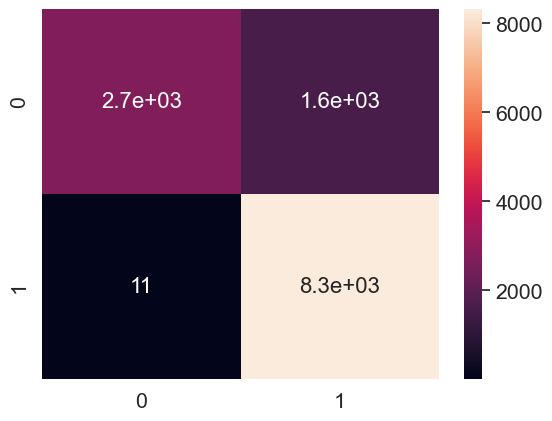

In [304]:
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat_1, annot=True, annot_kws={'size': 16}) # font size
plt.savefig('conf_mat_1.jpg',  bbox_inches='tight')

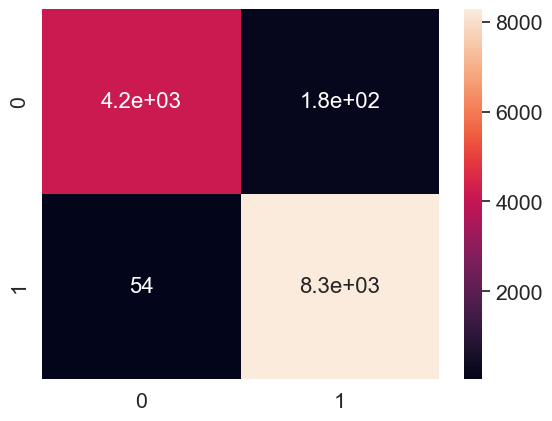

In [305]:
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat_2, annot=True, annot_kws={'size': 16}) # font size
plt.savefig('conf_mat_2.jpg',  bbox_inches='tight')

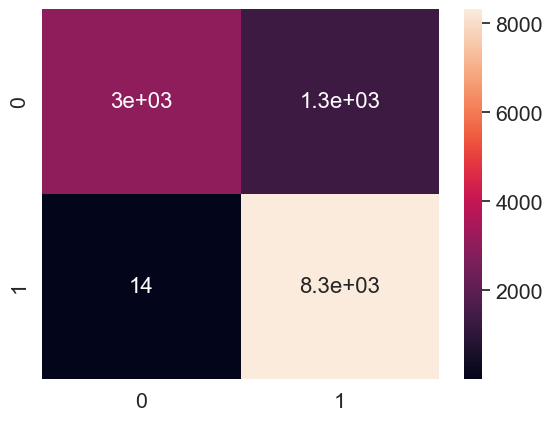

In [306]:
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat_3, annot=True, annot_kws={'size': 16}) # font size
plt.savefig('conf_mat_3.jpg',  bbox_inches='tight')

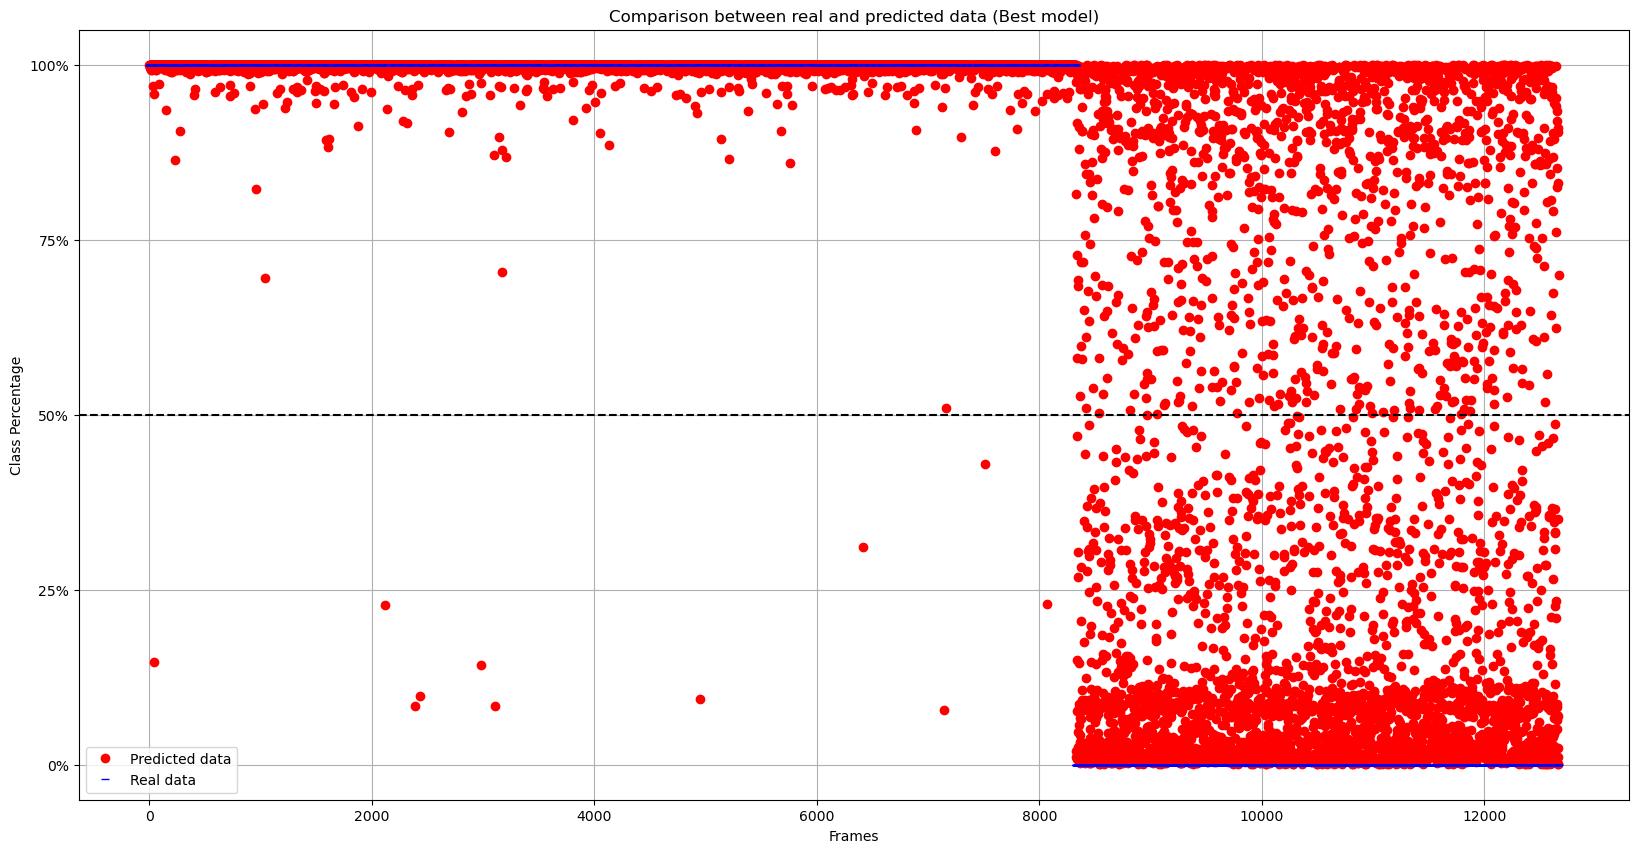

In [307]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(20,10))
ax.set(title='Comparison between real and predicted data (Best model)',
        xlabel='Frames',
        ylabel='Class Percentage')
ax.grid()
ax.set_yticks(np.arange(0, 101, 25))
ax.plot(np.arange(y_test.shape[0]), y_test_pred_1*100,'o', color='red')
ax.plot(np.arange(y_test.shape[0]), y_test*100,'_', color='blue')
plt.axhline(y=50, color='black', linestyle='--')
yticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(yticks)
ax.legend(['Predicted data', 'Real data'], loc='lower left');
plt.savefig(f'Comparison between the Real and predicted data (Best model).jpg',  bbox_inches='tight')

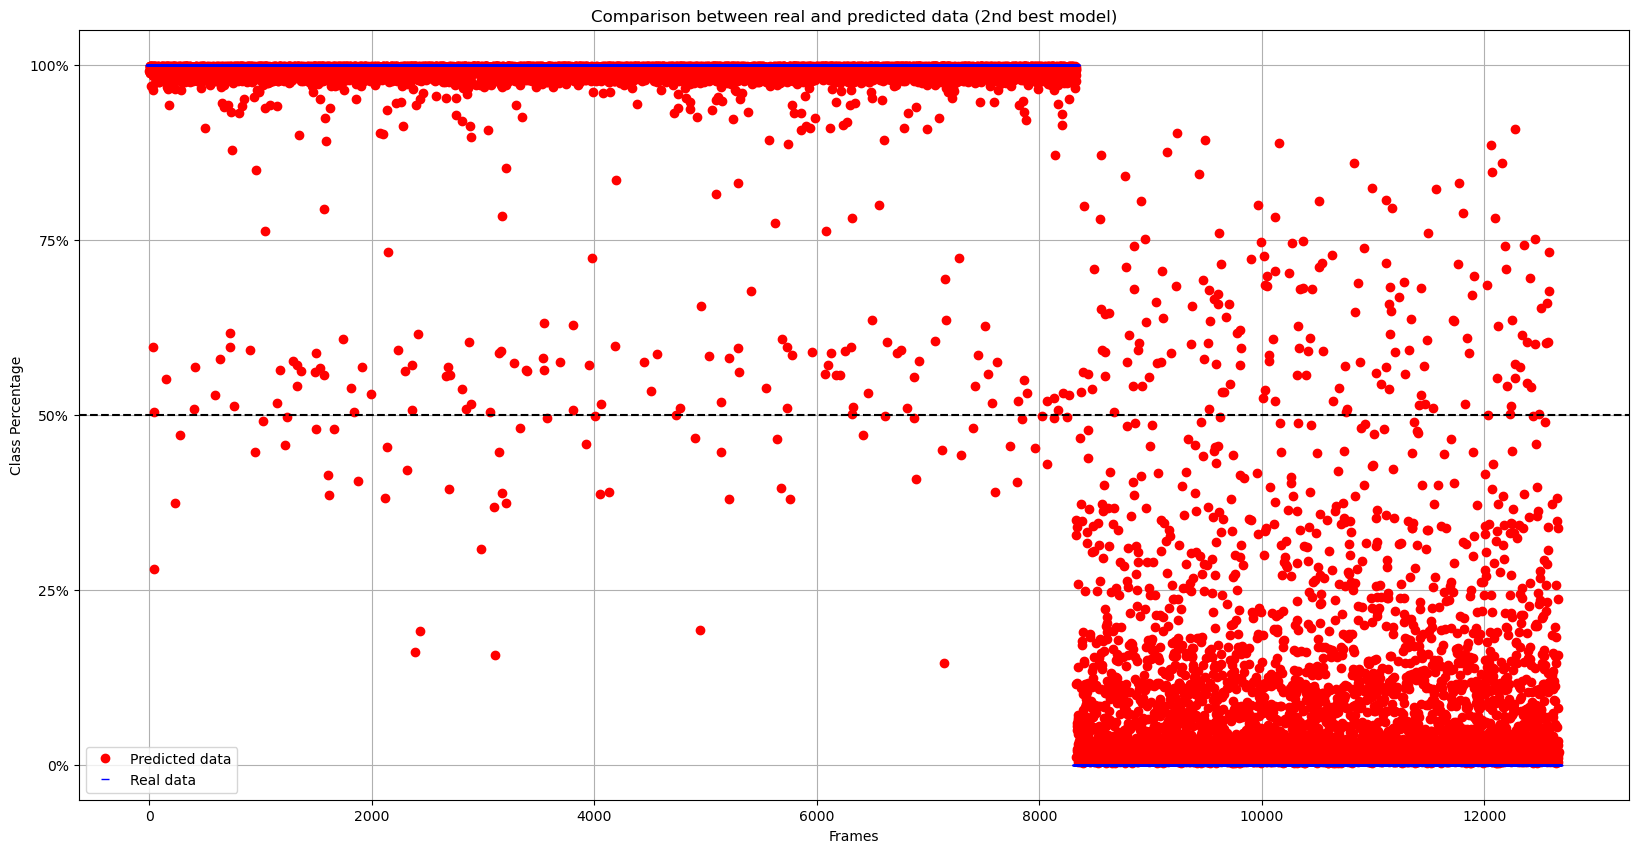

In [308]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(20,10))
ax.set(title='Comparison between real and predicted data (2nd best model)',
        xlabel='Frames',
        ylabel='Class Percentage')
ax.grid()
ax.set_yticks(np.arange(0, 101, 25))
ax.plot(np.arange(y_test.shape[0]), y_test_pred_2*100,'o', color='red')
ax.plot(np.arange(y_test.shape[0]), y_test*100,'_', color='blue')
plt.axhline(y=50, color='black', linestyle='--')
yticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(yticks)
ax.legend(['Predicted data', 'Real data'], loc='lower left');
plt.savefig(f'Comparison between real and predicted data (2nd best model).jpg',  bbox_inches='tight')

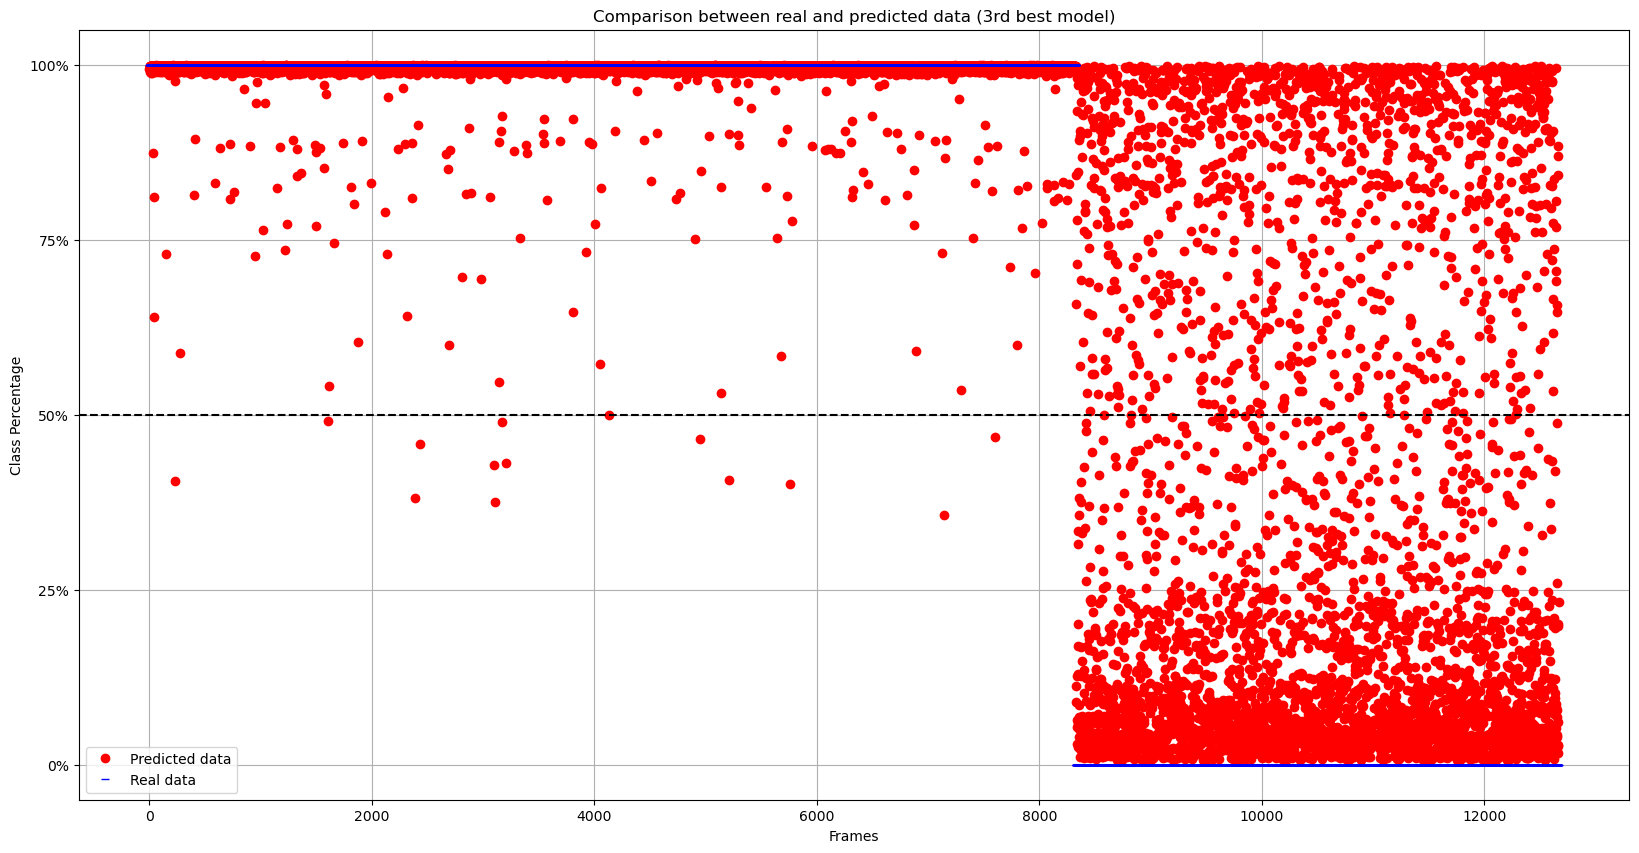

In [309]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(20,10))
ax.set(title='Comparison between real and predicted data (3rd best model)',
        xlabel='Frames',
        ylabel='Class Percentage')
ax.grid()
ax.set_yticks(np.arange(0, 101, 25))
ax.plot(np.arange(y_test.shape[0]), y_test_pred_3*100,'o', color='red')
ax.plot(np.arange(y_test.shape[0]), y_test*100,'_', color='blue')
plt.axhline(y=50, color='black', linestyle='--')
yticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(yticks)
ax.legend(['Predicted data', 'Real data'], loc='lower left');
plt.savefig('Comparison between real and predicted data (3rd best model).jpg',  bbox_inches='tight')